In [1]:
api_key='dZp6eWbDNqCGO0YGyWJz4HLZuoShjxjCPM8VIHFXnBUOvq0eMFO2ztXxGEBbXcmB'
api_secret=''

In [2]:
%config Completer.use_jedi = False

In [3]:
import pandas as pd
from binance.client import Client 
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
import math
import os.path
import time
import matplotlib.pyplot as plt
import numpy as np

## get data from binance

In [4]:
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
# binace_client=Client(api_key=api_key)

In [5]:
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new


In [6]:

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df


In [7]:
#data = get_all_binance("BTCUSDT","5m",save=True)

## read & analyze data 

In [8]:
!ls

BTCUSDT-5m-data.csv  Untitled.ipynb


In [9]:
data=pd.read_csv("BTCUSDT-5m-data.csv")

In [10]:
data.head()

timestamp     open     high      low    close    volume  \
0  2017-08-17 04:00:00  4261.48  4280.56  4261.48  4261.48  2.189061   
1  2017-08-17 04:05:00  4261.48  4261.48  4261.48  4261.48  0.000000   
2  2017-08-17 04:10:00  4261.48  4261.48  4261.48  4261.48  0.000000   
3  2017-08-17 04:15:00  4261.48  4264.88  4261.48  4261.48  0.484666   
4  2017-08-17 04:20:00  4264.88  4266.29  4264.88  4266.29  2.328570   

      close_time     quote_av  trades  tb_base_av  tb_quote_av       ignore  
0  1502942699999  9333.620962       9    0.489061  2089.104962  7960.375295  
1  1502942999999     0.000000       0    0.000000     0.000000  7959.626292  
2  1502943299999     0.000000       0    0.000000     0.000000  7958.417415  
3  1502943599999  2065.447829       9    0.085455   364.218136  7958.348965  
4  1502943899999  9931.161124      11    1.546491  6595.688039  7953.969349

In [11]:
data.shape

(388685, 12)

In [12]:
def train_test_split(df,test_size=0.2):
    split_row=df.shape[0] -int(test_size*df.shape[0])
    train_data=df.iloc[:split_row]
    test_data=df.iloc[split_row:]
    return train_data,test_data
    
    
    
    

In [13]:
train_data,test_data=train_test_split(data,test_size=0.01)

In [14]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);


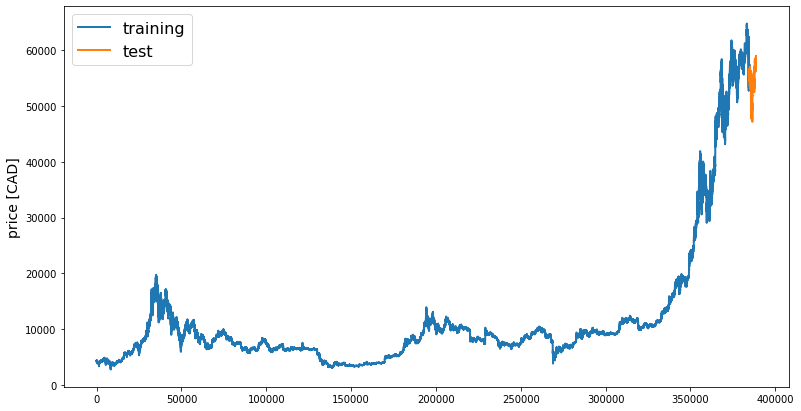

In [15]:
target_col = 'close'
line_plot(train_data[target_col], test_data[target_col], 'training', 'test', title='')

In [20]:
test_data.head()

timestamp      open      high       low     close  \
384799  2021-04-19 13:30:00  56230.01  56432.82  56225.30  56343.18   
384800  2021-04-19 13:35:00  56343.18  56587.33  56335.40  56585.68   
384801  2021-04-19 13:40:00  56585.68  56699.60  56550.01  56685.63   
384802  2021-04-19 13:45:00  56685.64  56685.64  56450.63  56472.80   
384803  2021-04-19 13:50:00  56472.80  56631.40  56353.45  56601.93   

            volume     close_time      quote_av  trades  tb_base_av  \
384799  256.450374  1618839299999  1.445404e+07    8302  110.278026   
384800  319.448742  1618839599999  1.804805e+07    9911  201.381406   
384801  517.275023  1618839899999  2.929369e+07   12815  271.616654   
384802  454.223535  1618840199999  2.568983e+07   14407  226.648305   
384803  383.428507  1618840499999  2.165771e+07   14190  222.095847   

         tb_quote_av  ignore  
384799  6.215368e+06     0.0  
384800  1.137734e+07     0.0  
384801  1.538178e+07     0.0  
384802  1.281877e+07     0.0  
384803  1.254497e+07     0.0

In [24]:
new_df=data[["open","high","low","close"]]
new_df.head()

open     high      low    close
0  4261.48  4280.56  4261.48  4261.48
1  4261.48  4261.48  4261.48  4261.48
2  4261.48  4261.48  4261.48  4261.48
3  4261.48  4264.88  4261.48  4261.48
4  4264.88  4266.29  4264.88  4266.29

In [17]:
def normalise_zero_base(df):
#     return df / df.iloc[0] - 1
    pass
##TODO fix this set numerical columns

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [27]:
def window_sliding_data(df,column_name,window_size=5,normalise_base=True):
    window=[]
    for index in range(df.shape[0]-window_size):
        temp=df[column_name][index:index+window_size].copy()
        if normalise_base==True:
            tmp=normalise_zero_base(temp)
        window.append(temp.values)
    return np.array(window)
        
    
    

In [29]:
window_sliding_data(test_data,'close')

array([[56343.18, 56585.68, 56685.63, 56472.8 , 56601.93],
       [56585.68, 56685.63, 56472.8 , 56601.93, 56630.91],
       [56685.63, 56472.8 , 56601.93, 56630.91, 56294.94],
       ...,
       [58834.98, 58787.87, 58712.87, 58690.66, 58629.03],
       [58787.87, 58712.87, 58690.66, 58629.03, 58710.69],
       [58712.87, 58690.66, 58629.03, 58710.69, 58705.01]])